Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/Mnist-autoencoder_epoch50.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FMnist-autoencoder_epoch50.ipynb&branch=main" target="_blank">Rosenblatt</a>

Exemple de réseau convolutionnel simple de type autoencodeur.

Cet exemple est censé être lu après avoir lu l'exemple "mnist", dont il est directement dérivé. Seuls les parties différentes sont commentées.

<br>
<br>
<br>
Imports des librairies, paramètres généraux et définition du jeu de données. Cette partie est quasi inchangée, seul le paramètre num_classes est supprimé ici, car on ne se trouve plus dans un problème de classification (les classes ne joueront aucun rôle). Il est remplacé par dim_code, la dimension de l'espace des codes, qui est fixée arbitrairement.

In [ ]:
#imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 50
dim_code = 12
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

<br>
<br>
<br>
Définition du réseau. On le sépare en deux parties, encodeur et décodeur. L'encodeur regroupe en fait les deux premières couches de l'exemple "mnist", tandis que le décodeur est constitué également de deux couches similaires, mais où les opérations de convolutions sont remplacées par des "transposées de convolution", ce qui est très proche mais permet d'augmenter la dimension des couches.

In [ ]:

# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self,dim_code):
        super(ConvNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fce = nn.Linear(7*7*32, dim_code)
        self.fcd = nn.Linear(dim_code, 7*7*32)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1))

    def forward(self, x):
        # encoding
        out = self.encoder(x)
        sz = out.size()
        out = out.reshape(out.size(0), -1)
        out = self.fce(out)
        # decoding
        out = self.fcd(out)
        out = out.reshape(sz)
        out = self.decoder(out)
        return out

model = ConvNet(dim_code).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

<br>
<br>
<br>
Entraînement du réseau. Ici la seule mais fondamentale différence est que la fonction coût évalue la différence
entre la sortie du réseau et les images d''entrée, et non plus entre la sortie et les classes.
Ici le critère utilisé est celui des moindres carrés.

In [ ]:
# Train the model
print("beginning training...")
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = ((outputs-images)**2).sum()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
print("training done")

beginning training...
Epoch [1/50], Step [100/600], Loss: 5122.1143
Epoch [1/50], Step [200/600], Loss: 4778.9819
Epoch [1/50], Step [300/600], Loss: 4381.7197
Epoch [1/50], Step [400/600], Loss: 3920.2595
Epoch [1/50], Step [500/600], Loss: 3679.3125
Epoch [1/50], Step [600/600], Loss: 3212.4456
Epoch [2/50], Step [100/600], Loss: 2970.0767
Epoch [2/50], Step [200/600], Loss: 2817.9521
Epoch [2/50], Step [300/600], Loss: 2680.3708
Epoch [2/50], Step [400/600], Loss: 2484.5640
Epoch [2/50], Step [500/600], Loss: 2715.4419
Epoch [2/50], Step [600/600], Loss: 2482.0679
Epoch [3/50], Step [100/600], Loss: 2654.3940
Epoch [3/50], Step [200/600], Loss: 2438.6021
Epoch [3/50], Step [300/600], Loss: 2529.5869
Epoch [3/50], Step [400/600], Loss: 2609.2881
Epoch [3/50], Step [500/600], Loss: 2459.7781
Epoch [3/50], Step [600/600], Loss: 2426.1140
Epoch [4/50], Step [100/600], Loss: 2283.7900
Epoch [4/50], Step [200/600], Loss: 2469.9773
Epoch [4/50], Step [300/600], Loss: 2338.4805
Epoch [4/50]

Epoch [30/50], Step [200/600], Loss: 1236.8289
Epoch [30/50], Step [300/600], Loss: 1137.2324
Epoch [30/50], Step [400/600], Loss: 1176.6002
Epoch [30/50], Step [500/600], Loss: 1138.8071
Epoch [30/50], Step [600/600], Loss: 1077.1548
Epoch [31/50], Step [100/600], Loss: 1131.6338
Epoch [31/50], Step [200/600], Loss: 1174.3989
Epoch [31/50], Step [300/600], Loss: 1242.7368
Epoch [31/50], Step [400/600], Loss: 1176.1660
Epoch [31/50], Step [500/600], Loss: 1189.8350
Epoch [31/50], Step [600/600], Loss: 1073.7418
Epoch [32/50], Step [100/600], Loss: 1142.8589
Epoch [32/50], Step [200/600], Loss: 1122.7643
Epoch [32/50], Step [300/600], Loss: 1113.0773
Epoch [32/50], Step [400/600], Loss: 1118.9520
Epoch [32/50], Step [500/600], Loss: 1210.4977
Epoch [32/50], Step [600/600], Loss: 1047.5056
Epoch [33/50], Step [100/600], Loss: 1102.6531
Epoch [33/50], Step [200/600], Loss: 1288.2141
Epoch [33/50], Step [300/600], Loss: 1189.6852
Epoch [33/50], Step [400/600], Loss: 1150.7252
Epoch [33/50]

<br>
<br>
<br>
On affiche la sortie du réseau pour les cinq premières images entrées. Ces sorties sont censées être des images très proches des images d'entrée car le réseau a été entraîné pour ça. Cependant la capacité à reproduire l'image d'entrée est limitée par le passage intermédiaire dans l'espace des codes, de dimension réduite.

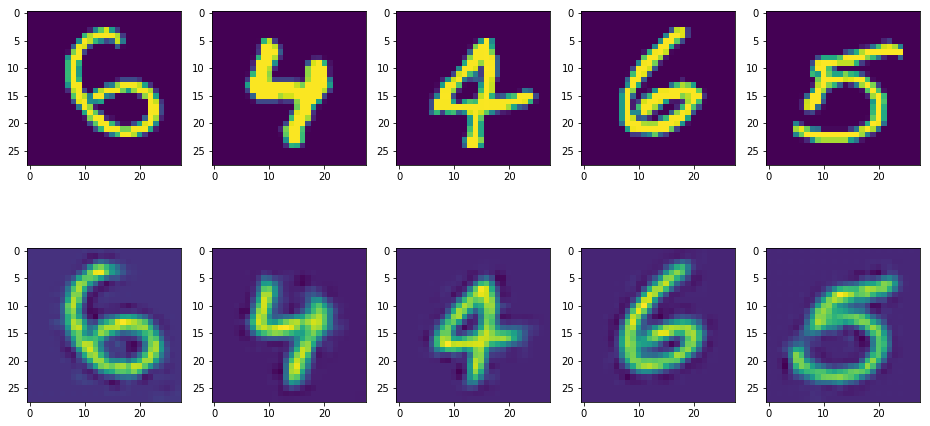

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
for k in range(5):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(images[k,0,:,:].cpu()))
for k in range(5):
    plt.subplot(2, 5, k+6)
    plt.imshow(np.squeeze(outputs[k,0,:,:].data.cpu()))
plt.show()

<br>
<br>
<br>
A présent on commence à explorer l'espace des codes : on va afficher des images de sorties correspondant à des codes aléatoires. Pour cela on construit des vecteurs aléatoires de la dimension du code puis on applique la partie décodage du réseau uniquement. On pourrait s'attendre à observer des images ressemblant à des images de chiffres ici ; cependant ce n'est pas le cas. On peut interpréter ceci en supposant que malgré la réduction de dimension opérée par le codage, les codes correspondant aux images de chiffres ne remplissent pas tout l'espace des codes.

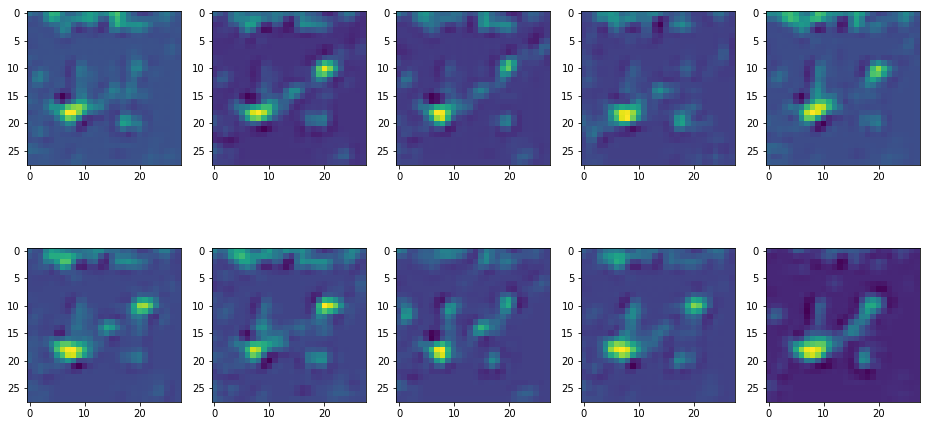

In [ ]:
code = torch.rand(10,dim_code,device=device)
out = model.fcd(code)
out = out.reshape(10,32,7,7)
out = model.decoder(out)
plt.rcParams['figure.figsize'] = [16, 8]
for k in range(10):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(out.data[k,0,:,:].cpu()))

<br>
<br>
<br>
A présent on va effectuer une moyenne dans l'espace des codes et observer l'image correspondante après décodage. On commence par sélectionner les images correspondant à des chiffres 3 et on applique à la main la partie encodage pour obtenir l'ensemble de leurs codes dans la variable code3

In [ ]:
images3 = images[labels==3,:,:,:]
n3 = images3.size(0)
out = model.encoder(images3)
out = out.reshape(out.size(0), -1)
code3 = model.fce(out)

Affichons les images décodées à la main à partir des codes (ceci n'est pas nécessaire pour la suite, juste un exercice)

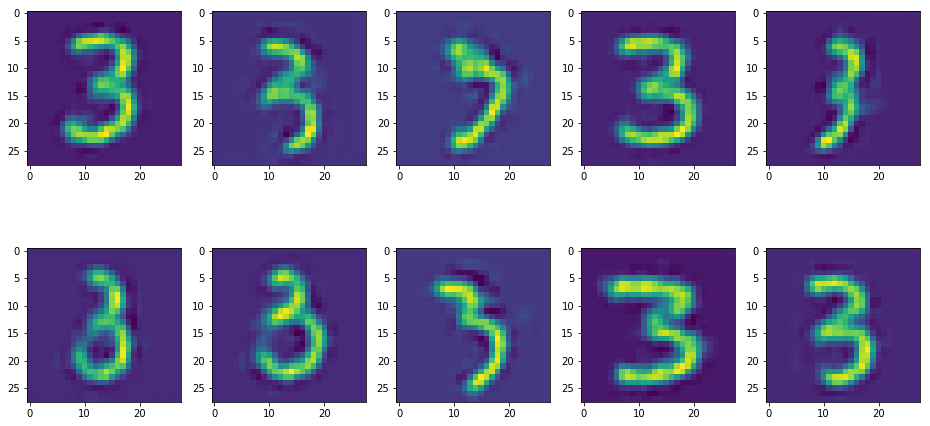

In [ ]:
out = model.fcd(code3)
out = out.reshape(n3,32,7,7)
out = model.decoder(out)
plt.rcParams['figure.figsize'] = [16, 8]
for k in range(min(10,len(code3))):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(out.data[k,0,:,:].cpu()))

<br>
<br>
<br>
On effectue à présent la moyenne dans l'espace des codes, on applique le décodage à la moyenne et on affiche l'image de sortie (à droite). On compare avec la moyenne des images dans l'espace d'origine (à gauche). On peut observer que l'image correspondant à la moyenne dans l'espace des codes est plus proche de l'idée intuitive d'un "3 moyen" ou "idéal".

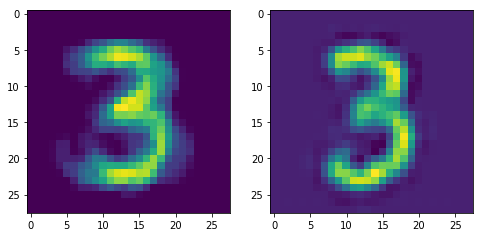

In [ ]:
code = code3.mean(dim=0).reshape(1,dim_code)
out = model.fcd(code)
out = out.reshape(1,32,7,7)
out = model.decoder(out)
mean3 = images3.mean(dim=0)
plt.rcParams['figure.figsize'] = [8, 4]
plt.subplot(1,2,1)
plt.imshow(np.squeeze(mean3.data[0,:,:].cpu()))
plt.subplot(1,2,2)
plt.imshow(np.squeeze(out.data[0,0,:,:].cpu()))
plt.show()

<br>
<br>
<br>
A présent on va effectuer une interpolation linéaire dans l''espace des codes entre deux codes correspondant à
des images des chiffres différents, et on va comparer avec l'interpolation dans l'espace des images (qui est une simple superposition pondérée des images). Ici encore on voit que l'interpolation dans l'espace des codes est plus proche de l'idée intuitive d'une transition progressive entre deux formes différentes de chiffre 3.

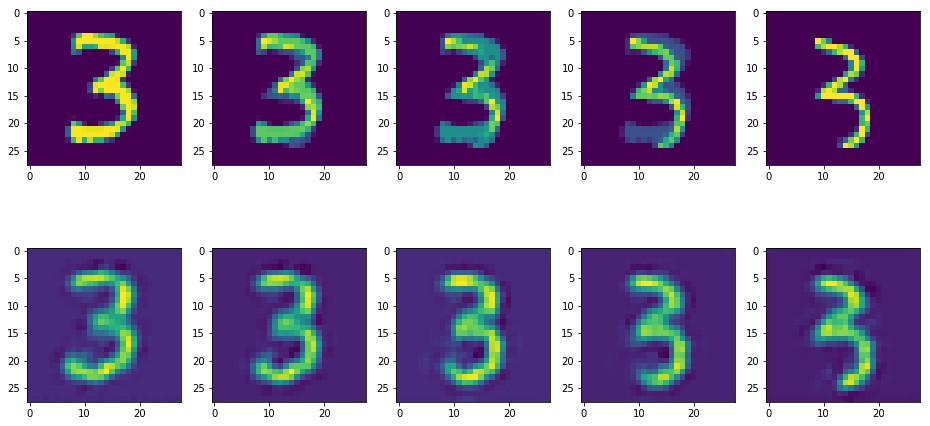

In [ ]:
k = 1
plt.rcParams['figure.figsize'] = [16, 8]
for p in np.linspace(0,1,5):
    image = (1-p)*images3.data[0,:]+p*images3.data[1,:]
    plt.subplot(2,5,k)
    plt.imshow(np.squeeze(image.data[0,:,:].cpu()))
    code = (1-p)*code3.data[0,:]+p*code3.data[1,:]
    out = model.fcd(code)
    out = out.reshape(1,32,7,7)
    out = model.decoder(out)
    plt.subplot(2,5,k+5)
    plt.imshow(np.squeeze(out.data[0,0,:,:].cpu()))
    k += 1

<br>
<br>
<br>
Même expérience avec deux chiffres différents et plus d'étapes intermédiaires. On peut observer ici parfois que l'interpolation entre un chiffre 7 et un 2 dans l'espace des codes passe par une forme intermédiaire proche d'un autre chiffre.

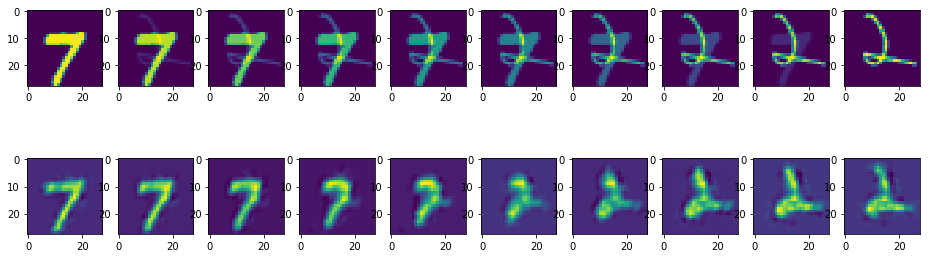

In [ ]:
k = 1
plt.rcParams['figure.figsize'] = [16, 5]
ind7, = np.where(labels.cpu().numpy()==7)
ind2, = np.where(labels.cpu().numpy()==2)
out = model.encoder(images[ind7[0]].unsqueeze(0))
out = out.reshape(out.size(0), -1)
code0 = model.fce(out)
out = model.encoder(images[ind2[2]].unsqueeze(0))
out = out.reshape(out.size(0), -1)
code1 = model.fce(out)
for p in np.linspace(0,1,10):
    image = (1-p)*images.data[ind7[0],:]+p*images.data[ind2[2],:]
    plt.subplot(2,10,k)
    plt.imshow(np.squeeze(image.data[0,:,:].cpu()));
    code = (1-p)*code0.data[0,:]+p*code1.data[0,:]
    out = model.fcd(code)
    out = out.reshape(1,32,7,7)
    out = model.decoder(out)
    plt.subplot(2,10,k+10)
    plt.imshow(np.squeeze(out.data[0,0,:,:].cpu()));
    k += 1